# Churn Modelling with ADMM optimizer

## Load dataset

In [1]:
import pandas as pd
churn_dataset = pd.read_csv('Churn_Modelling.csv')

In [2]:
churn_dataset.head()

,CreditScore,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,2,125510.82,1,1,1,79084.10,0


## Separate dependent and independent variables

In [3]:
X = churn_dataset.iloc[:,:-1].values
y = churn_dataset.iloc[:,-1].values

In [4]:
X

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

In [5]:
y

array([1, 0, 1, ..., 1, 1, 0])

## Test and train split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data preprocessing

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), [1, 2]) 
    ],
    remainder='passthrough' 
)

X_train = column_transformer.fit_transform(X_train)

X_test = column_transformer.transform(X_test)

In [8]:
X_train.shape

(8000, 12)

In [9]:
X_test.shape

(2000, 12)

In [10]:
X_train[:5, :]

array([[1.0, 0.0, 0.0, 0.0, 1.0, 686, 6, 0.0, 2, 1, 1, 179093.26],
       [0.0, 1.0, 0.0, 0.0, 1.0, 632, 4, 119624.6, 2, 1, 1, 195978.86],
       [0.0, 0.0, 1.0, 0.0, 1.0, 559, 3, 114739.92, 1, 1, 0, 85891.02],
       [1.0, 0.0, 0.0, 1.0, 0.0, 561, 9, 135637.0, 1, 1, 0, 153080.4],
       [1.0, 0.0, 0.0, 0.0, 1.0, 517, 9, 142147.32, 1, 0, 0, 39488.04]],
      dtype=object)

## Feature scaling

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
X_train[:5, :]

array([[ 1.00150113, -0.57946723, -0.57638802, -0.91324755,  0.91324755,
         0.35649971,  0.34567966, -1.21847056,  0.80843615,  0.64920267,
         0.97481699,  1.36766974],
       [-0.99850112,  1.72572313, -0.57638802, -0.91324755,  0.91324755,
        -0.20389777, -0.3483691 ,  0.69683765,  0.80843615,  0.64920267,
         0.97481699,  1.6612541 ],
       [-0.99850112, -0.57946723,  1.73494238, -0.91324755,  0.91324755,
        -0.96147213, -0.69539349,  0.61862909, -0.91668767,  0.64920267,
        -1.02583358, -0.25280688],
       [ 1.00150113, -0.57946723, -0.57638802,  1.09499335, -1.09499335,
        -0.94071667,  1.38675281,  0.95321202, -0.91668767,  0.64920267,
        -1.02583358,  0.91539272],
       [ 1.00150113, -0.57946723, -0.57638802, -0.91324755,  0.91324755,
        -1.39733684,  1.38675281,  1.05744869, -0.91668767, -1.54035103,
        -1.02583358, -1.05960019]])

## Initialize neural network

In [13]:
import torch
import torch.nn as nn

In [14]:
# Convert all numpy arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [15]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [16]:
model = LogisticRegressionModel(X_train.shape[1])

## ADMM hyper parameters

In [17]:
alpha = 0.1
u = torch.zeros_like(model.linear.weight, dtype=torch.float32) # Dual variable initialized to zero
z = torch.zeros_like(model.linear.weight, dtype=torch.float32) # Proximal variable initialied to zero
loss_fn = nn.BCELoss()

## Soft thresholding function

In [18]:
def soft_thresholding(x, alpha):
    return torch.sign(x) * torch.max(torch.abs(x) - alpha, torch.zeros_like(x))

## Logistic regression parameters

In [19]:
epochs = 10000
learning_rate = 0.01

In [20]:
# Optimizer for primal variable update
import torch.optim as optim

primal_optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training loop

In [21]:
training_loss_list = []
epoch_list = []

for epoch in range(epochs):
    model.train()
    
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    
    # primal variable update
    l1_penalty = alpha * torch.sum(torch.abs(model.linear.weight - z + u))**2
    total_loss = loss + l1_penalty

    primal_optimizer.zero_grad()
    total_loss.backward()
    primal_optimizer.step()
    
    training_loss_list.append(total_loss.item())
    epoch_list.append(epoch)
    
    # proximal update using soft-thresholding
    with torch.no_grad():
        z = soft_thresholding(model.linear.weight.data, alpha)
    
    # dual update
    with torch.no_grad():
        u = u + (model.linear.weight.data - z)
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}')

Epoch [1000/10000], Loss: 0.5269
Epoch [2000/10000], Loss: 0.5198
Epoch [3000/10000], Loss: 0.5196
Epoch [4000/10000], Loss: 0.5195
Epoch [5000/10000], Loss: 0.5196
Epoch [6000/10000], Loss: 0.5197
Epoch [7000/10000], Loss: 0.5197
Epoch [8000/10000], Loss: 0.5197
Epoch [9000/10000], Loss: 0.5197
Epoch [10000/10000], Loss: 0.5198


## Evaluate model based on test dataset

In [22]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test_labels = (y_pred_test > 0.5).float()  
    accuracy = (y_pred_test_labels == y_test).float().mean()
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8035


## Visualization of training

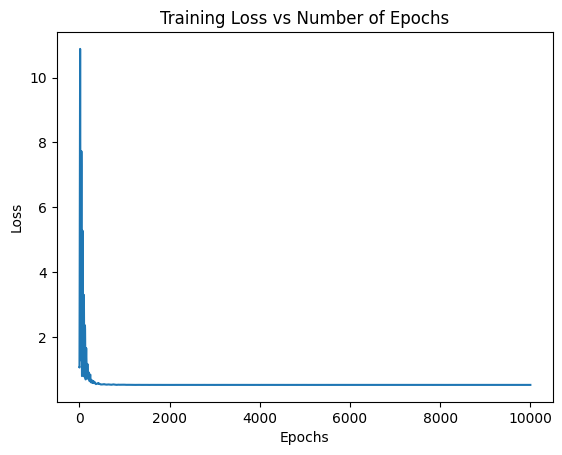

In [23]:
import matplotlib.pyplot as plt

plt.plot(epoch_list,training_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Number of Epochs")
plt.show()